# DESI DR1 Stream Tutorial

Welcome to the 2025 version of our stellar stream characterization tutorial notebook. This notebook will walk you through using data from the DESI Milky Way Survey data from the first full public release!

Below, we're going to import the packages we'll be using.

#-----------------------#

Look here for stuff to change throughout the notebook!

#-----------------------#

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats
from astropy.io import fits
from astropy import table
import matplotlib
import matplotlib.patheffects as path_effects
import importlib
import stream_functions as stream_funcs
importlib.reload(stream_funcs)
import galstreams
import emcee
import corner
from astropy import units as u
from collections import OrderedDict
import time
from scipy import optimize, stats
import matplotlib.colors as mcolors
colors = mcolors.CSS4_COLORS
color_names = list(colors.keys())
import streamTutorial as st
import copy
importlib.reload(st);


Next, let's input our DESI MWS DR1 data. 

In [57]:
importlib.reload(st)
# Add the path to the DESI data and STREAMFINDER data below
#-----------------------#
desi_path = '/raid/DESI_public/data/mwsall-pix-iron.fits'
sf_path = '/raid/catalogs/streamfinder_gaiadr3.fits'
#-----------------------#

Data = st.Data(desi_path, sf_path)

print('Now our desi data has been loaded under Data.desi_data')


Length of DESI Data before Cuts: 6372607
Length after NaN cut: 4075716
Adding empirical FEH calibration (can find uncalibrated data in column['FEH_uncalib])
Length after NaN cut: 4075716
Adding empirical FEH calibration (can find uncalibrated data in column['FEH_uncalib])
Now our desi data has been loaded under Data.desi_data
Now our desi data has been loaded under Data.desi_data


# Pick Stream

We'll pick a stream to work with by entering it in 
`st.stream(Data, streamName='SoI-I21', streamNo=42)`.

Initializing this stream object will add an attribute to the `Data` object, accessed either through

`Data.confirmed_sf_and_desi` or `SoI.data.confirmed_sf_and_desi`

It will also calculate the *stream coordinates* $\phi_1$ and $\phi_2$. This is achieved by rotating the right ascension and declination such that the length of the stream lies along $\phi_2 \sim 0$, and the center of the stream is $\phi_1 \sim 0$.

In [58]:
del SoI

NameError: name 'SoI' is not defined

In [59]:
importlib.reload(stream_funcs)
SoI = st.stream(Data)#, streamName='C-19-I21', streamNo=85)

Importing galstreams module...
Initializing galstreams library from master_log... 
2.4107524852223685
Creating combined DataFrame of SF and DESI
2.4107524852223685
Creating combined DataFrame of SF and DESI
No original data available for comparison - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 256, Number of DESI and SF stars: 93
Saved merged DataFrame as self.data.confirmed_sf_and_desi
No original data available for comparison - cut_confirmed_sf_and_desi is empty
Number of stars in SF: 256, Number of DESI and SF stars: 93
Saved merged DataFrame as self.data.confirmed_sf_and_desi
Stars only in SF3: 155
Stars only in SF3: 155


Lets take a look at the rotated stream below

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:494: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



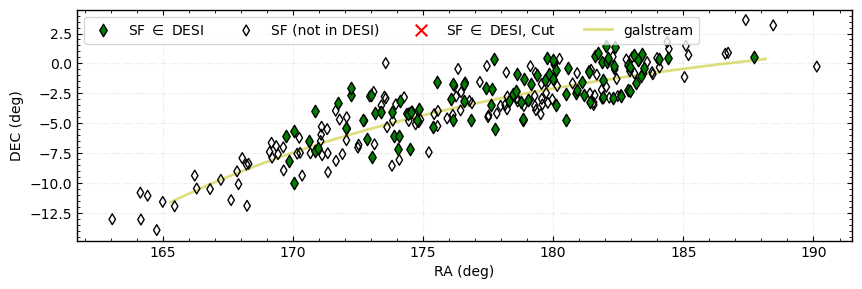

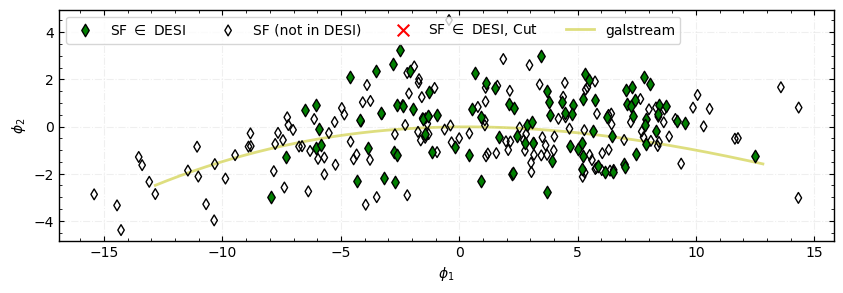

In [60]:
importlib.reload(st)
plt_soi = st.StreamPlotter(SoI)

plt_soi.on_sky(stream_frame=False)
plt_soi.on_sky(stream_frame=True)

# Trimming DESI Data
We have lots of DESI data, lets cut that down with the following steps:
- Perform a distance cut to remove stars too nearby
- Perform an RA/DEC cut to remove stars on different parts of the sky
- Trim stars with kinematics nothing like the STREAMFINDER stars
- Trim stars that are too metal rich
- Trim stars that fall outside of the best-fit stellar population model

The first two bullet points can be achieved using a handy function we have stored in `stream_functions.py`

`stream_funcs.threeD_max_min_mask`

In [61]:
selection_fine = st.Selection(SoI.data.desi_data)

# We want to get the ra and dec from STREAMFINDER stars for this function so we can cut around it


#-----------------------#
ra_cut = 1 #deg
dec_cut = 1 #deg
#-----------------------#

selection_fine.add_mask(name='3D',
        mask_func=lambda df: stream_funcs.threeD_max_min_mask(
        df['TARGET_RA'],        
        df['TARGET_DEC'],         
        df['PARALLAX'],       
        df['PARALLAX_ERROR'],   
        SoI.data.SoI_streamfinder['RAdeg'],         
        SoI.data.SoI_streamfinder['DEdeg'],        
        SoI.min_dist,              
        ra_cut,dec_cut) #<-----------------------# dec cut, ra cut (wide cuts for now)
)

Selection object created for DataFrame with 4075716 rows.
Mask added: '3D'


Once we've done all our cuts, we can get all our masks in one using `final_mask = st.Selection.get_final_mask()`

Combining masks...
...'3D' selected 153185 stars
Selection: 153185 / 4075716 stars.
0
Created cut_confirmed_sf_and_desi with 1 stars that were filtered out
Number of stars in SF: 256, Number of DESI and SF stars: 92
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 156
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:494: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:494: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



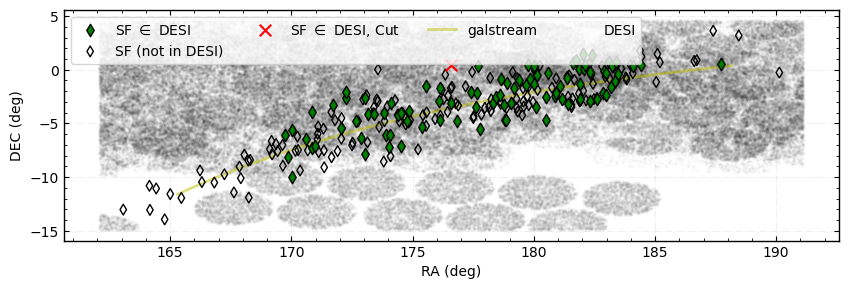

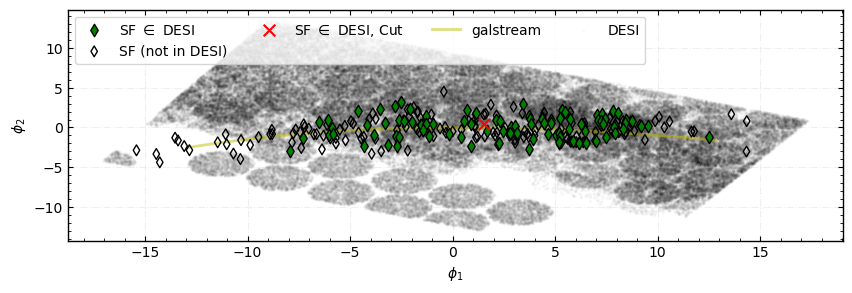

In [62]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data

final_mask = selection_fine.get_final_mask()

trimmed_desi = SoI.data.select(final_mask)

trimmed_stream = copy.copy(SoI)
trimmed_stream.data=trimmed_desi
trimmed_stream.data.sfCrossMatch(); trimmed_stream.data.sfCrossMatch(False) # getting subset of SF stars


plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.on_sky(showStream=True, background=True, stream_frame=False)
plt_trim.on_sky(showStream=True, background=True)


Lets also look at our parallax cut:

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:560: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



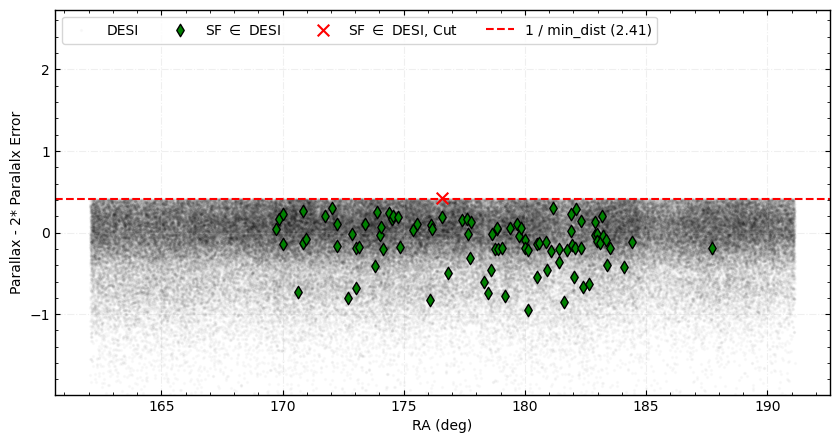

In [63]:
plt_trim.plx_cut()

del plt_trim, trimmed_desi, trimmed_stream # clear memory

Now that we've visualized the stream in the stream-frame, we can get a bit more specific with our on-sky cuts.

In [64]:
#-----------------------#
phi2_wiggle=5 #[deg]
#-----------------------#

selection_fine.add_mask(name='phi2',
        mask_func=lambda df: (df['phi2'] < phi2_wiggle) & (df['phi2'] > -1*phi2_wiggle))

Mask added: 'phi2'


Combining masks...
...'3D' selected 153185 stars
...'phi2' selected 593800 stars
Selection: 96044 / 4075716 stars.
0
Created cut_confirmed_sf_and_desi with 1 stars that were filtered out
Number of stars in SF: 256, Number of DESI and SF stars: 92
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 156
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:494: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:494: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(



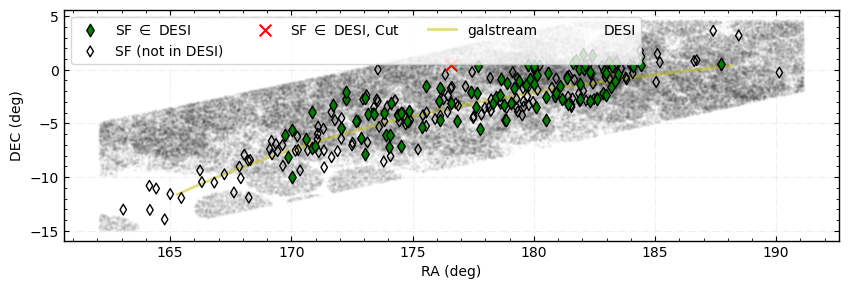

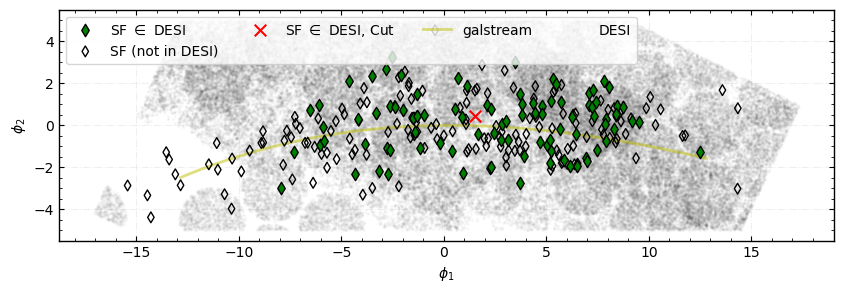

In [65]:
importlib.reload(st)
# Lets take a look at our trimmed DESI data
final_mask = selection_fine.get_final_mask()

trimmed_desi = SoI.data.select(final_mask)

trimmed_stream = copy.copy(SoI)
trimmed_stream.data=trimmed_desi
trimmed_stream.data.sfCrossMatch(); trimmed_stream.data.sfCrossMatch(False) # getting subset of SF stars


plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.on_sky(showStream=True, background=True, stream_frame=False)
plt_trim.on_sky(showStream=True, background=True)

# Kinematic Cuts

DESI's radial velocity

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:617: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:622: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:627: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[2].scatter(



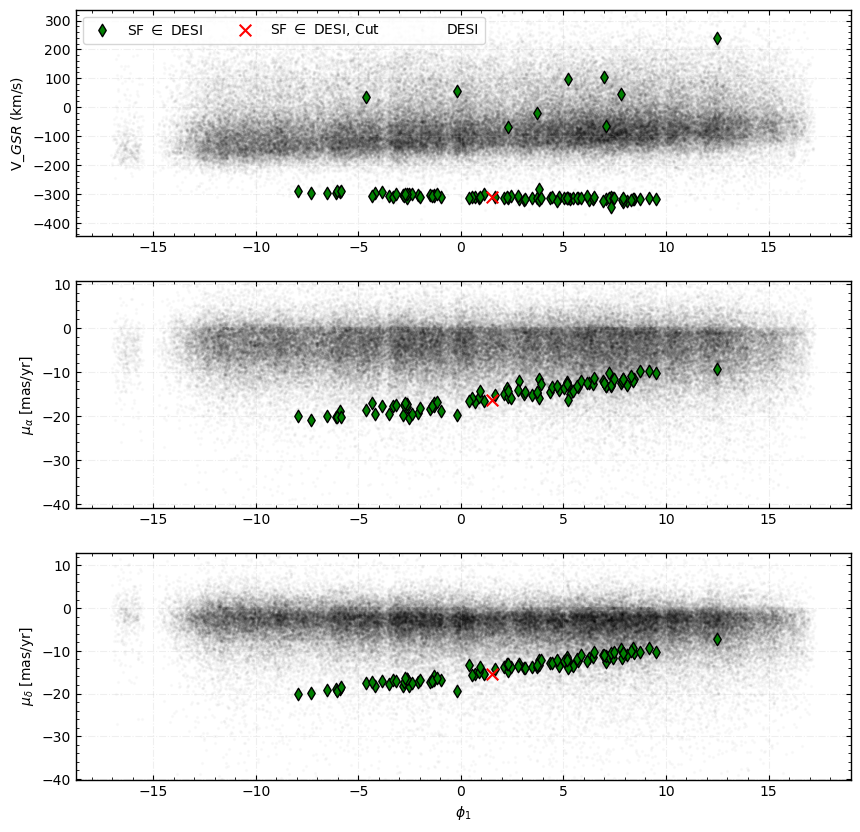

In [66]:
importlib.reload(st)
plt_trim.kin_plot(showStream=True, background=True)

In [67]:
#-----------------------#
vgsr_max=-200 #[km/s]
vgsr_min=-400
#-----------------------#

selection_fine.add_mask(name='VGSR',
        mask_func=lambda df: (df['VGSR'] < vgsr_max) & (df['VGSR'] > vgsr_min))

Mask added: 'VGSR'


In [68]:
#-----------------------#
pmra_max= -5 #[mas/yr]
pmra_min= -30
#-----------------------#

selection_fine.add_mask(name='PMRA',
        mask_func=lambda df: (df['PMRA'] < pmra_max) & (df['PMRA'] > pmra_min))

Mask added: 'PMRA'


In [69]:
#-----------------------#
pmdec_max= -5 #[mas/yr]
pmdec_min= -30
#-----------------------#

selection_fine.add_mask(name='PMDEC',
        mask_func=lambda df: (df['PMDEC'] < pmdec_max) & (df['PMDEC'] > pmdec_min))

Mask added: 'PMDEC'


## Lets look at our cuts!
If you don't see a clear stream in VGSR, go back and try again :(

Combining masks...
...'3D' selected 153185 stars
...'phi2' selected 593800 stars
...'VGSR' selected 46599 stars
...'PMRA' selected 1158279 stars
...'PMDEC' selected 1567985 stars
Selection: 261 / 4075716 stars.
0
Created cut_confirmed_sf_and_desi with 10 stars that were filtered out
Number of stars in SF: 256, Number of DESI and SF stars: 83
Saved merged DataFrame as self.data.confirmed_sf_and_desi_b
Stars only in SF3: 165
/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:617: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(

/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/streamTutorial.py:622: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(

/home/j

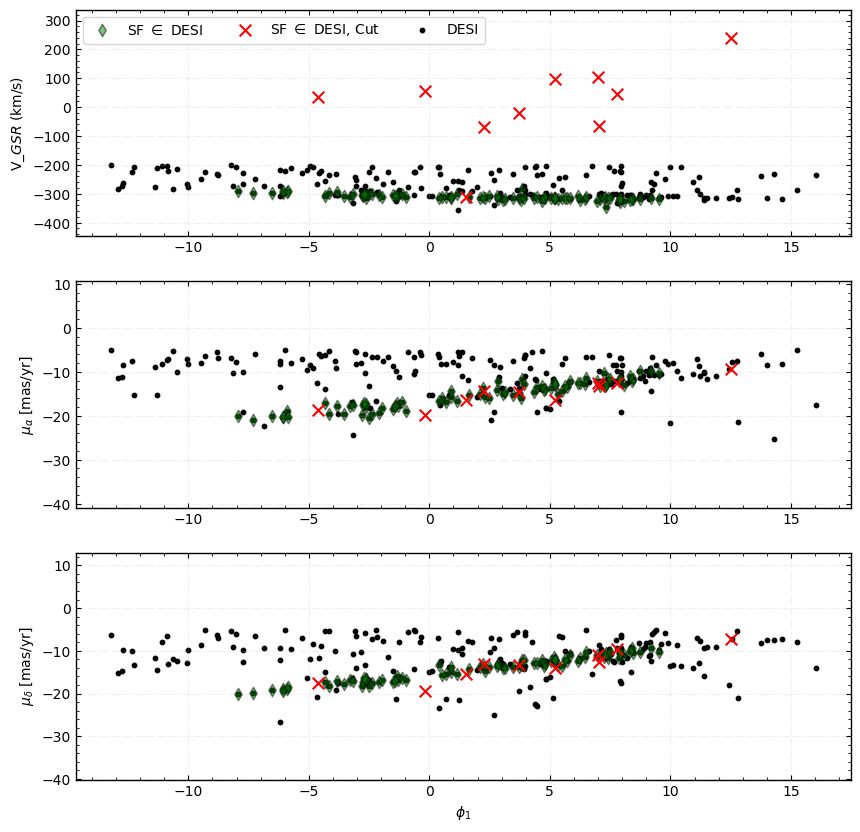

In [72]:
importlib.reload(st)
del plt_trim, trimmed_desi, trimmed_stream
# Lets take a look at our trimmed DESI data
final_mask = selection_fine.get_final_mask()

trimmed_desi = SoI.data.select(final_mask)

trimmed_stream = copy.copy(SoI)
trimmed_stream.data=trimmed_desi
trimmed_stream.data.sfCrossMatch(); trimmed_stream.data.sfCrossMatch(False) # getting subset of SF stars


plt_trim = st.StreamPlotter(trimmed_stream)
plt_trim.plot_params['sf_in_desi']['alpha']=0.5
plt_trim.plot_params['background']['alpha']=1
plt_trim.plot_params['background']['s'] = 10
#-----------------------#
plt_trim.kin_plot(showStream=True, background=True) # You can change showStream to True to see where the STREAMFINDER stars are in this space.
#-----------------------#

Lets look at an example of a stream being spotted once our initial cuts have been made. We can see lines of overdensities in all three kinematic dimensions!

 Furthermore, we can overlay the STREAMFINDER stars to see that this overdensity lies on the previously disovered stream, and which SF stars we have cutout.

<img src="/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/img_examples/ex_stream.png" alt="Stream Image" width="600"/> <img src="/home/jupyter-nasserm/raid/nasserm/streamTutorialDr1/img_examples/ex-sf.png" alt="Stream Image" width="600"/>